<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:14:22] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


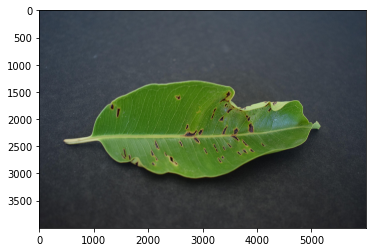

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

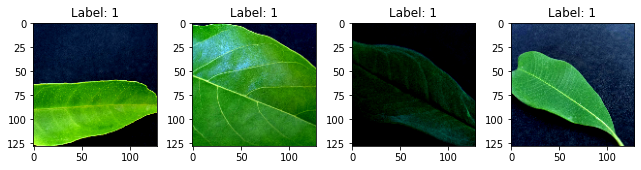

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:14:28] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:14:29] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2588916283621474 samples/sec                   batch loss = 0.7804533839225769 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.2667936338417785 samples/sec                   batch loss = 0.5042205452919006 | accuracy = 0.625


Epoch[1] Batch[15] Speed: 1.2742813281035077 samples/sec                   batch loss = 0.9191517233848572 | accuracy = 0.5833333333333334


Epoch[1] Batch[20] Speed: 1.2652551326185542 samples/sec                   batch loss = 1.0407085418701172 | accuracy = 0.6


Epoch[1] Batch[25] Speed: 1.2640008498388282 samples/sec                   batch loss = 2.3555264472961426 | accuracy = 0.61


Epoch[1] Batch[30] Speed: 1.2769643453950374 samples/sec                   batch loss = 0.41632482409477234 | accuracy = 0.625


Epoch[1] Batch[35] Speed: 1.2669651602282124 samples/sec                   batch loss = 0.5387174487113953 | accuracy = 0.6357142857142857


Epoch[1] Batch[40] Speed: 1.2667456186017505 samples/sec                   batch loss = 0.6131412386894226 | accuracy = 0.63125


Epoch[1] Batch[45] Speed: 1.262573818829123 samples/sec                   batch loss = 0.7077782154083252 | accuracy = 0.65


Epoch[1] Batch[50] Speed: 1.2680132158274007 samples/sec                   batch loss = 0.5694870352745056 | accuracy = 0.65


Epoch[1] Batch[55] Speed: 1.2666409924201079 samples/sec                   batch loss = 0.6309235095977783 | accuracy = 0.65


Epoch[1] Batch[60] Speed: 1.2688053138337476 samples/sec                   batch loss = 1.0938471555709839 | accuracy = 0.6541666666666667


Epoch[1] Batch[65] Speed: 1.264994500733977 samples/sec                   batch loss = 0.37125250697135925 | accuracy = 0.65


Epoch[1] Batch[70] Speed: 1.2703801694520096 samples/sec                   batch loss = 0.49040892720222473 | accuracy = 0.6464285714285715


Epoch[1] Batch[75] Speed: 1.2626704568118376 samples/sec                   batch loss = 0.4354032278060913 | accuracy = 0.6466666666666666


Epoch[1] Batch[80] Speed: 1.2704565519978972 samples/sec                   batch loss = 0.6030232906341553 | accuracy = 0.64375


Epoch[1] Batch[85] Speed: 1.2727961439560411 samples/sec                   batch loss = 0.45903828740119934 | accuracy = 0.65


Epoch[1] Batch[90] Speed: 1.2670346258425518 samples/sec                   batch loss = 0.604770302772522 | accuracy = 0.6583333333333333


Epoch[1] Batch[95] Speed: 1.2673005983663612 samples/sec                   batch loss = 0.2970517575740814 | accuracy = 0.6631578947368421


Epoch[1] Batch[100] Speed: 1.2619213059246883 samples/sec                   batch loss = 0.7658132314682007 | accuracy = 0.6575


Epoch[1] Batch[105] Speed: 1.2673085438474652 samples/sec                   batch loss = 0.8962758183479309 | accuracy = 0.6595238095238095


Epoch[1] Batch[110] Speed: 1.272199874988275 samples/sec                   batch loss = 0.6947557926177979 | accuracy = 0.6613636363636364


Epoch[1] Batch[115] Speed: 1.271933867265247 samples/sec                   batch loss = 0.7786959409713745 | accuracy = 0.6652173913043479


Epoch[1] Batch[120] Speed: 1.2789047465682808 samples/sec                   batch loss = 1.6128380298614502 | accuracy = 0.6666666666666666


Epoch[1] Batch[125] Speed: 1.2570992185209984 samples/sec                   batch loss = 0.39540842175483704 | accuracy = 0.666


Epoch[1] Batch[130] Speed: 1.2680770456671921 samples/sec                   batch loss = 0.48888853192329407 | accuracy = 0.6634615384615384


Epoch[1] Batch[135] Speed: 1.2693508636725495 samples/sec                   batch loss = 0.29403620958328247 | accuracy = 0.6703703703703704


Epoch[1] Batch[140] Speed: 1.2638934392668864 samples/sec                   batch loss = 0.8046252727508545 | accuracy = 0.6660714285714285


Epoch[1] Batch[145] Speed: 1.2644129501290209 samples/sec                   batch loss = 0.6848974227905273 | accuracy = 0.6620689655172414


Epoch[1] Batch[150] Speed: 1.2666494077808885 samples/sec                   batch loss = 0.7359235882759094 | accuracy = 0.66


Epoch[1] Batch[155] Speed: 1.2652331865555038 samples/sec                   batch loss = 0.6863115429878235 | accuracy = 0.6629032258064517


Epoch[1] Batch[160] Speed: 1.2653426381869564 samples/sec                   batch loss = 0.5916800498962402 | accuracy = 0.6625


Epoch[1] Batch[165] Speed: 1.2720120762636369 samples/sec                   batch loss = 0.4052042067050934 | accuracy = 0.6651515151515152


Epoch[1] Batch[170] Speed: 1.272500352498614 samples/sec                   batch loss = 0.05918283388018608 | accuracy = 0.6720588235294118


Epoch[1] Batch[175] Speed: 1.2663307540582898 samples/sec                   batch loss = 0.8423762321472168 | accuracy = 0.6742857142857143


Epoch[1] Batch[180] Speed: 1.261749149719722 samples/sec                   batch loss = 0.35076573491096497 | accuracy = 0.6708333333333333


Epoch[1] Batch[185] Speed: 1.26539522369044 samples/sec                   batch loss = 1.2699748277664185 | accuracy = 0.668918918918919


Epoch[1] Batch[190] Speed: 1.2669225852076968 samples/sec                   batch loss = 0.3919943869113922 | accuracy = 0.6723684210526316


Epoch[1] Batch[195] Speed: 1.2661954249401892 samples/sec                   batch loss = 0.7278969883918762 | accuracy = 0.6717948717948717


Epoch[1] Batch[200] Speed: 1.2638128933168684 samples/sec                   batch loss = 0.24859507381916046 | accuracy = 0.67


Epoch[1] Batch[205] Speed: 1.2702800394987876 samples/sec                   batch loss = 0.5000836849212646 | accuracy = 0.6707317073170732


Epoch[1] Batch[210] Speed: 1.2679061763020603 samples/sec                   batch loss = 0.3684675693511963 | accuracy = 0.6738095238095239


Epoch[1] Batch[215] Speed: 1.2726273792428553 samples/sec                   batch loss = 1.1658204793930054 | accuracy = 0.6744186046511628


Epoch[1] Batch[220] Speed: 1.2677863173182127 samples/sec                   batch loss = 0.6514963507652283 | accuracy = 0.6761363636363636


Epoch[1] Batch[225] Speed: 1.2637860469481772 samples/sec                   batch loss = 0.4071624279022217 | accuracy = 0.6744444444444444


Epoch[1] Batch[230] Speed: 1.2618096932391125 samples/sec                   batch loss = 0.7597830295562744 | accuracy = 0.675


Epoch[1] Batch[235] Speed: 1.2729401313849718 samples/sec                   batch loss = 0.6998777389526367 | accuracy = 0.675531914893617


Epoch[1] Batch[240] Speed: 1.2708214679029868 samples/sec                   batch loss = 0.2555081248283386 | accuracy = 0.675


Epoch[1] Batch[245] Speed: 1.2688198032866826 samples/sec                   batch loss = 0.5022755265235901 | accuracy = 0.673469387755102


Epoch[1] Batch[250] Speed: 1.2638334572643046 samples/sec                   batch loss = 0.43988025188446045 | accuracy = 0.673


Epoch[1] Batch[255] Speed: 1.2583570120717313 samples/sec                   batch loss = 0.8568596839904785 | accuracy = 0.6735294117647059


Epoch[1] Batch[260] Speed: 1.263985422729762 samples/sec                   batch loss = 0.4423675537109375 | accuracy = 0.6730769230769231


Epoch[1] Batch[265] Speed: 1.2664905867074023 samples/sec                   batch loss = 0.8134728074073792 | accuracy = 0.6716981132075471


Epoch[1] Batch[270] Speed: 1.277991730067124 samples/sec                   batch loss = 0.3121906518936157 | accuracy = 0.6731481481481482


Epoch[1] Batch[275] Speed: 1.269693427890485 samples/sec                   batch loss = 0.19036276638507843 | accuracy = 0.6754545454545454


Epoch[1] Batch[280] Speed: 1.268930356232276 samples/sec                   batch loss = 0.6791784763336182 | accuracy = 0.6767857142857143


Epoch[1] Batch[285] Speed: 1.2712955362999192 samples/sec                   batch loss = 0.26199203729629517 | accuracy = 0.6780701754385965


Epoch[1] Batch[290] Speed: 1.2763217333103891 samples/sec                   batch loss = 0.26056015491485596 | accuracy = 0.6801724137931034


Epoch[1] Batch[295] Speed: 1.2705290950597523 samples/sec                   batch loss = 0.3761735260486603 | accuracy = 0.6788135593220339


Epoch[1] Batch[300] Speed: 1.275218029680114 samples/sec                   batch loss = 0.18654002249240875 | accuracy = 0.68


Epoch[1] Batch[305] Speed: 1.2707593827598869 samples/sec                   batch loss = 0.4814518094062805 | accuracy = 0.6827868852459016


Epoch[1] Batch[310] Speed: 1.2731111044333776 samples/sec                   batch loss = 1.1415332555770874 | accuracy = 0.6806451612903226


Epoch[1] Batch[315] Speed: 1.2732175752609354 samples/sec                   batch loss = 0.8235169649124146 | accuracy = 0.6793650793650794


Epoch[1] Batch[320] Speed: 1.2741826144399022 samples/sec                   batch loss = 0.8110312223434448 | accuracy = 0.67890625


Epoch[1] Batch[325] Speed: 1.2746922186348988 samples/sec                   batch loss = 0.2541462779045105 | accuracy = 0.6807692307692308


Epoch[1] Batch[330] Speed: 1.2610538853256243 samples/sec                   batch loss = 0.6829129457473755 | accuracy = 0.6818181818181818


Epoch[1] Batch[335] Speed: 1.2721174952232706 samples/sec                   batch loss = 0.7345618605613708 | accuracy = 0.6828358208955224


Epoch[1] Batch[340] Speed: 1.2705963539193497 samples/sec                   batch loss = 0.6110334396362305 | accuracy = 0.6808823529411765


Epoch[1] Batch[345] Speed: 1.2744431741787479 samples/sec                   batch loss = 0.3019760847091675 | accuracy = 0.6833333333333333


Epoch[1] Batch[350] Speed: 1.277574526632635 samples/sec                   batch loss = 0.5357798337936401 | accuracy = 0.6842857142857143


Epoch[1] Batch[355] Speed: 1.263550856796501 samples/sec                   batch loss = 0.22222007811069489 | accuracy = 0.6866197183098591


Epoch[1] Batch[360] Speed: 1.2655404052724615 samples/sec                   batch loss = 0.27279946208000183 | accuracy = 0.6881944444444444


Epoch[1] Batch[365] Speed: 1.2765588853045973 samples/sec                   batch loss = 0.8041266202926636 | accuracy = 0.6835616438356165


Epoch[1] Batch[370] Speed: 1.2725554650915307 samples/sec                   batch loss = 0.5961363911628723 | accuracy = 0.6858108108108109


Epoch[1] Batch[375] Speed: 1.2718548965441956 samples/sec                   batch loss = 0.43869537115097046 | accuracy = 0.686


Epoch[1] Batch[380] Speed: 1.2678833716482045 samples/sec                   batch loss = 1.0181375741958618 | accuracy = 0.6848684210526316


Epoch[1] Batch[385] Speed: 1.2706724737501625 samples/sec                   batch loss = 0.6551114320755005 | accuracy = 0.6831168831168831


Epoch[1] Batch[390] Speed: 1.2695976334647612 samples/sec                   batch loss = 0.7586399912834167 | accuracy = 0.6820512820512821


Epoch[1] Batch[395] Speed: 1.2736642317524345 samples/sec                   batch loss = 0.46143633127212524 | accuracy = 0.6829113924050633


Epoch[1] Batch[400] Speed: 1.2738829863526877 samples/sec                   batch loss = 0.977138340473175 | accuracy = 0.68375


Epoch[1] Batch[405] Speed: 1.2662627991693205 samples/sec                   batch loss = 0.4456775188446045 | accuracy = 0.6858024691358025


Epoch[1] Batch[410] Speed: 1.2723406398129424 samples/sec                   batch loss = 0.5059188604354858 | accuracy = 0.6878048780487804


Epoch[1] Batch[415] Speed: 1.2740691126321981 samples/sec                   batch loss = 0.3706800937652588 | accuracy = 0.689156626506024


Epoch[1] Batch[420] Speed: 1.270280616571448 samples/sec                   batch loss = 0.3735910654067993 | accuracy = 0.6892857142857143


Epoch[1] Batch[425] Speed: 1.2657829261156543 samples/sec                   batch loss = 0.7070674300193787 | accuracy = 0.6888235294117647


Epoch[1] Batch[430] Speed: 1.268382290959084 samples/sec                   batch loss = 0.42980217933654785 | accuracy = 0.688953488372093


Epoch[1] Batch[435] Speed: 1.264807774234606 samples/sec                   batch loss = 0.7966257929801941 | accuracy = 0.6867816091954023


Epoch[1] Batch[440] Speed: 1.2699931069867418 samples/sec                   batch loss = 0.35714495182037354 | accuracy = 0.6880681818181819


Epoch[1] Batch[445] Speed: 1.2703380379227784 samples/sec                   batch loss = 0.7357560992240906 | accuracy = 0.6882022471910112


Epoch[1] Batch[450] Speed: 1.2713853245965523 samples/sec                   batch loss = 1.0088756084442139 | accuracy = 0.6877777777777778


Epoch[1] Batch[455] Speed: 1.2656486688417106 samples/sec                   batch loss = 0.8987826108932495 | accuracy = 0.6868131868131868


Epoch[1] Batch[460] Speed: 1.259037872410233 samples/sec                   batch loss = 0.5212852954864502 | accuracy = 0.6869565217391305


Epoch[1] Batch[465] Speed: 1.2687888096944895 samples/sec                   batch loss = 0.4209345281124115 | accuracy = 0.6876344086021505


Epoch[1] Batch[470] Speed: 1.2696028215588906 samples/sec                   batch loss = 0.9390304684638977 | accuracy = 0.6867021276595745


Epoch[1] Batch[475] Speed: 1.2679507339803777 samples/sec                   batch loss = 0.8131920695304871 | accuracy = 0.6852631578947368


Epoch[1] Batch[480] Speed: 1.2687275946022487 samples/sec                   batch loss = 0.5528947114944458 | accuracy = 0.6854166666666667


Epoch[1] Batch[485] Speed: 1.2589706979599564 samples/sec                   batch loss = 0.4643855392932892 | accuracy = 0.6860824742268041


Epoch[1] Batch[490] Speed: 1.2684155662079148 samples/sec                   batch loss = 0.5978893637657166 | accuracy = 0.686734693877551


Epoch[1] Batch[495] Speed: 1.2643058506154867 samples/sec                   batch loss = 0.40690264105796814 | accuracy = 0.6878787878787879


Epoch[1] Batch[500] Speed: 1.2682850643572487 samples/sec                   batch loss = 0.535308301448822 | accuracy = 0.687


Epoch[1] Batch[505] Speed: 1.2692995814096497 samples/sec                   batch loss = 0.7491088509559631 | accuracy = 0.6876237623762376


Epoch[1] Batch[510] Speed: 1.2624567707995107 samples/sec                   batch loss = 0.31372013688087463 | accuracy = 0.6897058823529412


Epoch[1] Batch[515] Speed: 1.2660095856903595 samples/sec                   batch loss = 0.5738928318023682 | accuracy = 0.6912621359223301


Epoch[1] Batch[520] Speed: 1.269465927721958 samples/sec                   batch loss = 0.6416878700256348 | accuracy = 0.6899038461538461


Epoch[1] Batch[525] Speed: 1.259312786014835 samples/sec                   batch loss = 0.5089401006698608 | accuracy = 0.6904761904761905


Epoch[1] Batch[530] Speed: 1.2509605399618102 samples/sec                   batch loss = 0.9387169480323792 | accuracy = 0.6882075471698114


Epoch[1] Batch[535] Speed: 1.2629678753197182 samples/sec                   batch loss = 0.7604919672012329 | accuracy = 0.6864485981308411


Epoch[1] Batch[540] Speed: 1.2675187044806515 samples/sec                   batch loss = 0.6415935754776001 | accuracy = 0.687037037037037


Epoch[1] Batch[545] Speed: 1.264942234646214 samples/sec                   batch loss = 0.42297419905662537 | accuracy = 0.6871559633027523


Epoch[1] Batch[550] Speed: 1.261544881943643 samples/sec                   batch loss = 0.5033197999000549 | accuracy = 0.6863636363636364


Epoch[1] Batch[555] Speed: 1.2606563804682154 samples/sec                   batch loss = 0.4775378108024597 | accuracy = 0.6864864864864865


Epoch[1] Batch[560] Speed: 1.2657029030597373 samples/sec                   batch loss = 0.502530574798584 | accuracy = 0.6888392857142858


Epoch[1] Batch[565] Speed: 1.2682937892126942 samples/sec                   batch loss = 0.6149826049804688 | accuracy = 0.6884955752212389


Epoch[1] Batch[570] Speed: 1.262247620497879 samples/sec                   batch loss = 0.6263855695724487 | accuracy = 0.6881578947368421


Epoch[1] Batch[575] Speed: 1.2700969415865886 samples/sec                   batch loss = 0.4908512234687805 | accuracy = 0.6882608695652174


Epoch[1] Batch[580] Speed: 1.2637833814135315 samples/sec                   batch loss = 0.8159032464027405 | accuracy = 0.6887931034482758


Epoch[1] Batch[585] Speed: 1.2636266106380973 samples/sec                   batch loss = 0.432423859834671 | accuracy = 0.6884615384615385


Epoch[1] Batch[590] Speed: 1.2649771418097497 samples/sec                   batch loss = 0.5440260767936707 | accuracy = 0.6885593220338984


Epoch[1] Batch[595] Speed: 1.2662851632643002 samples/sec                   batch loss = 0.3737785816192627 | accuracy = 0.688655462184874


Epoch[1] Batch[600] Speed: 1.265661845037669 samples/sec                   batch loss = 0.9855645298957825 | accuracy = 0.6895833333333333


Epoch[1] Batch[605] Speed: 1.264811588320399 samples/sec                   batch loss = 0.4733462333679199 | accuracy = 0.6904958677685951


Epoch[1] Batch[610] Speed: 1.26317517206465 samples/sec                   batch loss = 0.6306331157684326 | accuracy = 0.6889344262295082


Epoch[1] Batch[615] Speed: 1.2666470170420228 samples/sec                   batch loss = 0.6376923322677612 | accuracy = 0.6894308943089431


Epoch[1] Batch[620] Speed: 1.2652170614552591 samples/sec                   batch loss = 0.6858326196670532 | accuracy = 0.6879032258064516


Epoch[1] Batch[625] Speed: 1.2662002985800278 samples/sec                   batch loss = 0.20816665887832642 | accuracy = 0.6888


Epoch[1] Batch[630] Speed: 1.2608600763194933 samples/sec                   batch loss = 0.2713530659675598 | accuracy = 0.6892857142857143


Epoch[1] Batch[635] Speed: 1.263612905752577 samples/sec                   batch loss = 0.6169750690460205 | accuracy = 0.6893700787401574


Epoch[1] Batch[640] Speed: 1.2636937117641915 samples/sec                   batch loss = 0.26157137751579285 | accuracy = 0.691015625


Epoch[1] Batch[645] Speed: 1.26695999366868 samples/sec                   batch loss = 0.5073500871658325 | accuracy = 0.6922480620155039


Epoch[1] Batch[650] Speed: 1.2741046221068166 samples/sec                   batch loss = 0.12425217032432556 | accuracy = 0.691923076923077


Epoch[1] Batch[655] Speed: 1.2667219949093185 samples/sec                   batch loss = 0.8329920768737793 | accuracy = 0.6912213740458015


Epoch[1] Batch[660] Speed: 1.2661136298392357 samples/sec                   batch loss = 0.809926450252533 | accuracy = 0.6901515151515152


Epoch[1] Batch[665] Speed: 1.2610075363340172 samples/sec                   batch loss = 0.2136888951063156 | accuracy = 0.6906015037593985


Epoch[1] Batch[670] Speed: 1.2623986348783378 samples/sec                   batch loss = 0.3386296331882477 | accuracy = 0.6899253731343283


Epoch[1] Batch[675] Speed: 1.2703847867758107 samples/sec                   batch loss = 0.6074938774108887 | accuracy = 0.6903703703703704


Epoch[1] Batch[680] Speed: 1.2734016707403812 samples/sec                   batch loss = 0.12684299051761627 | accuracy = 0.6915441176470588


Epoch[1] Batch[685] Speed: 1.279292188495562 samples/sec                   batch loss = 0.3385846018791199 | accuracy = 0.691970802919708


Epoch[1] Batch[690] Speed: 1.2634721623621783 samples/sec                   batch loss = 0.6159566044807434 | accuracy = 0.6923913043478261


Epoch[1] Batch[695] Speed: 1.2689615486985806 samples/sec                   batch loss = 0.5820776224136353 | accuracy = 0.6928057553956835


Epoch[1] Batch[700] Speed: 1.2681670509089535 samples/sec                   batch loss = 0.41962170600891113 | accuracy = 0.6939285714285715


Epoch[1] Batch[705] Speed: 1.2656583122625602 samples/sec                   batch loss = 0.3618316054344177 | accuracy = 0.6929078014184397


Epoch[1] Batch[710] Speed: 1.2627939126846117 samples/sec                   batch loss = 0.45909780263900757 | accuracy = 0.6936619718309859


Epoch[1] Batch[715] Speed: 1.2637084654496897 samples/sec                   batch loss = 0.38634130358695984 | accuracy = 0.6937062937062937


Epoch[1] Batch[720] Speed: 1.2587675176286708 samples/sec                   batch loss = 0.9464215040206909 | accuracy = 0.6934027777777778


Epoch[1] Batch[725] Speed: 1.2678783892279863 samples/sec                   batch loss = 0.351696640253067 | accuracy = 0.6931034482758621


Epoch[1] Batch[730] Speed: 1.2669273687751772 samples/sec                   batch loss = 0.444328635931015 | accuracy = 0.6931506849315069


Epoch[1] Batch[735] Speed: 1.2724514211499833 samples/sec                   batch loss = 0.7642502784729004 | accuracy = 0.6925170068027211


Epoch[1] Batch[740] Speed: 1.25991879459683 samples/sec                   batch loss = 0.8703720569610596 | accuracy = 0.6922297297297297


Epoch[1] Batch[745] Speed: 1.259588292533944 samples/sec                   batch loss = 0.3676936626434326 | accuracy = 0.6932885906040268


Epoch[1] Batch[750] Speed: 1.26089760143192 samples/sec                   batch loss = 0.4618555009365082 | accuracy = 0.6933333333333334


Epoch[1] Batch[755] Speed: 1.2592807428076982 samples/sec                   batch loss = 0.7222027778625488 | accuracy = 0.6933774834437086


Epoch[1] Batch[760] Speed: 1.264936989200712 samples/sec                   batch loss = 0.5476419925689697 | accuracy = 0.6930921052631579


Epoch[1] Batch[765] Speed: 1.2665103774079862 samples/sec                   batch loss = 0.4811292886734009 | accuracy = 0.6931372549019608


Epoch[1] Batch[770] Speed: 1.258579792346385 samples/sec                   batch loss = 0.3896881639957428 | accuracy = 0.6941558441558442


Epoch[1] Batch[775] Speed: 1.2636642054266587 samples/sec                   batch loss = 0.31786808371543884 | accuracy = 0.6948387096774193


Epoch[1] Batch[780] Speed: 1.269520201395357 samples/sec                   batch loss = 0.6963323950767517 | accuracy = 0.694551282051282


Epoch[1] Batch[785] Speed: 1.2655531018927986 samples/sec                   batch loss = 0.16771508753299713 | accuracy = 0.6949044585987261


[Epoch 1] training: accuracy=0.694479695431472
[Epoch 1] time cost: 650.4997081756592
[Epoch 1] validation: validation accuracy=0.7066666666666667


Epoch[2] Batch[5] Speed: 1.2658674483249108 samples/sec                   batch loss = 0.6328060626983643 | accuracy = 0.6


Epoch[2] Batch[10] Speed: 1.269635488310718 samples/sec                   batch loss = 0.36455830931663513 | accuracy = 0.675


Epoch[2] Batch[15] Speed: 1.2655413598967122 samples/sec                   batch loss = 0.6549142599105835 | accuracy = 0.65


Epoch[2] Batch[20] Speed: 1.2611363551456174 samples/sec                   batch loss = 0.29213839769363403 | accuracy = 0.675


Epoch[2] Batch[25] Speed: 1.2609492494942025 samples/sec                   batch loss = 0.35600516200065613 | accuracy = 0.71


Epoch[2] Batch[30] Speed: 1.2620088255984478 samples/sec                   batch loss = 0.2420436441898346 | accuracy = 0.7333333333333333


Epoch[2] Batch[35] Speed: 1.2684315811430797 samples/sec                   batch loss = 1.0434801578521729 | accuracy = 0.7357142857142858


Epoch[2] Batch[40] Speed: 1.268219392100086 samples/sec                   batch loss = 0.6589637994766235 | accuracy = 0.7375


Epoch[2] Batch[45] Speed: 1.269501757431809 samples/sec                   batch loss = 0.2340245097875595 | accuracy = 0.7555555555555555


Epoch[2] Batch[50] Speed: 1.2648193119145847 samples/sec                   batch loss = 0.5482019782066345 | accuracy = 0.745


Epoch[2] Batch[55] Speed: 1.271396789895159 samples/sec                   batch loss = 0.47141098976135254 | accuracy = 0.740909090909091


Epoch[2] Batch[60] Speed: 1.2664469919836756 samples/sec                   batch loss = 0.5916890501976013 | accuracy = 0.7416666666666667


Epoch[2] Batch[65] Speed: 1.2726525752506737 samples/sec                   batch loss = 0.3516637980937958 | accuracy = 0.7423076923076923


Epoch[2] Batch[70] Speed: 1.2659080420985025 samples/sec                   batch loss = 0.7326750159263611 | accuracy = 0.7357142857142858


Epoch[2] Batch[75] Speed: 1.2630357622650545 samples/sec                   batch loss = 0.24716439843177795 | accuracy = 0.7433333333333333


Epoch[2] Batch[80] Speed: 1.2676424398232713 samples/sec                   batch loss = 0.4946730434894562 | accuracy = 0.734375


Epoch[2] Batch[85] Speed: 1.266560860836596 samples/sec                   batch loss = 0.9027206301689148 | accuracy = 0.7264705882352941


Epoch[2] Batch[90] Speed: 1.269381884730532 samples/sec                   batch loss = 0.9661095142364502 | accuracy = 0.7194444444444444


Epoch[2] Batch[95] Speed: 1.2702461854870204 samples/sec                   batch loss = 0.8828699588775635 | accuracy = 0.718421052631579


Epoch[2] Batch[100] Speed: 1.26677278215496 samples/sec                   batch loss = 0.6467410922050476 | accuracy = 0.715


Epoch[2] Batch[105] Speed: 1.2657008978386495 samples/sec                   batch loss = 0.4744134545326233 | accuracy = 0.7119047619047619


Epoch[2] Batch[110] Speed: 1.2710730470070506 samples/sec                   batch loss = 0.6879007816314697 | accuracy = 0.7136363636363636


Epoch[2] Batch[115] Speed: 1.2688582835064992 samples/sec                   batch loss = 0.25764429569244385 | accuracy = 0.7152173913043478


Epoch[2] Batch[120] Speed: 1.2714097006470033 samples/sec                   batch loss = 0.646908164024353 | accuracy = 0.7145833333333333


Epoch[2] Batch[125] Speed: 1.2695866809608416 samples/sec                   batch loss = 0.45745739340782166 | accuracy = 0.718


Epoch[2] Batch[130] Speed: 1.270535734029563 samples/sec                   batch loss = 0.3099755644798279 | accuracy = 0.7211538461538461


Epoch[2] Batch[135] Speed: 1.2705353491598534 samples/sec                   batch loss = 0.5665149092674255 | accuracy = 0.7203703703703703


Epoch[2] Batch[140] Speed: 1.2735356445338075 samples/sec                   batch loss = 0.2937105596065521 | accuracy = 0.7232142857142857


Epoch[2] Batch[145] Speed: 1.2764320436694365 samples/sec                   batch loss = 0.619398295879364 | accuracy = 0.7155172413793104


Epoch[2] Batch[150] Speed: 1.2668474879335028 samples/sec                   batch loss = 0.19155387580394745 | accuracy = 0.7183333333333334


Epoch[2] Batch[155] Speed: 1.2685051399617147 samples/sec                   batch loss = 0.36005112528800964 | accuracy = 0.714516129032258


Epoch[2] Batch[160] Speed: 1.2791154554376154 samples/sec                   batch loss = 1.1446985006332397 | accuracy = 0.709375


Epoch[2] Batch[165] Speed: 1.2756424244755957 samples/sec                   batch loss = 0.2734599709510803 | accuracy = 0.7151515151515152


Epoch[2] Batch[170] Speed: 1.2750175173007094 samples/sec                   batch loss = 0.2602188289165497 | accuracy = 0.7191176470588235


Epoch[2] Batch[175] Speed: 1.280694712784416 samples/sec                   batch loss = 0.5963025093078613 | accuracy = 0.72


Epoch[2] Batch[180] Speed: 1.2662684379051146 samples/sec                   batch loss = 0.31437209248542786 | accuracy = 0.725


Epoch[2] Batch[185] Speed: 1.2619526293588217 samples/sec                   batch loss = 0.14006265997886658 | accuracy = 0.731081081081081


Epoch[2] Batch[190] Speed: 1.2690208666036993 samples/sec                   batch loss = 0.13149882853031158 | accuracy = 0.7342105263157894


Epoch[2] Batch[195] Speed: 1.2679901198260555 samples/sec                   batch loss = 0.546858012676239 | accuracy = 0.7346153846153847


Epoch[2] Batch[200] Speed: 1.265929533973853 samples/sec                   batch loss = 0.13194964826107025 | accuracy = 0.73875


Epoch[2] Batch[205] Speed: 1.2641342814758376 samples/sec                   batch loss = 0.10963498055934906 | accuracy = 0.7378048780487805


Epoch[2] Batch[210] Speed: 1.2607002405722034 samples/sec                   batch loss = 1.1768169403076172 | accuracy = 0.7392857142857143


Epoch[2] Batch[215] Speed: 1.2657686014361238 samples/sec                   batch loss = 0.7359172701835632 | accuracy = 0.7395348837209302


Epoch[2] Batch[220] Speed: 1.2677643791586057 samples/sec                   batch loss = 0.5661196112632751 | accuracy = 0.7386363636363636


Epoch[2] Batch[225] Speed: 1.2679544712183255 samples/sec                   batch loss = 0.3809952437877655 | accuracy = 0.7377777777777778


Epoch[2] Batch[230] Speed: 1.2664468007853575 samples/sec                   batch loss = 0.5281370878219604 | accuracy = 0.7369565217391304


Epoch[2] Batch[235] Speed: 1.2737310493474272 samples/sec                   batch loss = 0.4888686537742615 | accuracy = 0.7382978723404255


Epoch[2] Batch[240] Speed: 1.2763708656752026 samples/sec                   batch loss = 0.46597111225128174 | accuracy = 0.7395833333333334


Epoch[2] Batch[245] Speed: 1.2716197780753804 samples/sec                   batch loss = 0.386325478553772 | accuracy = 0.7397959183673469


Epoch[2] Batch[250] Speed: 1.2735598130820547 samples/sec                   batch loss = 1.7812718152999878 | accuracy = 0.738


Epoch[2] Batch[255] Speed: 1.2726541198659835 samples/sec                   batch loss = 0.2900386452674866 | accuracy = 0.7382352941176471


Epoch[2] Batch[260] Speed: 1.2687634785950628 samples/sec                   batch loss = 0.46330416202545166 | accuracy = 0.7413461538461539


Epoch[2] Batch[265] Speed: 1.273685407626466 samples/sec                   batch loss = 0.3978712856769562 | accuracy = 0.7415094339622641


Epoch[2] Batch[270] Speed: 1.2755757941301764 samples/sec                   batch loss = 0.6816248297691345 | accuracy = 0.7379629629629629


Epoch[2] Batch[275] Speed: 1.274158519015035 samples/sec                   batch loss = 0.9296444058418274 | accuracy = 0.7372727272727273


Epoch[2] Batch[280] Speed: 1.2667985120877767 samples/sec                   batch loss = 0.5674336552619934 | accuracy = 0.7392857142857143


Epoch[2] Batch[285] Speed: 1.2728681818840497 samples/sec                   batch loss = 0.22679436206817627 | accuracy = 0.7403508771929824


Epoch[2] Batch[290] Speed: 1.271828189496246 samples/sec                   batch loss = 0.46687668561935425 | accuracy = 0.7396551724137931


Epoch[2] Batch[295] Speed: 1.2743527598796958 samples/sec                   batch loss = 0.22265975177288055 | accuracy = 0.7415254237288136


Epoch[2] Batch[300] Speed: 1.271834552806608 samples/sec                   batch loss = 0.33721688389778137 | accuracy = 0.7391666666666666


Epoch[2] Batch[305] Speed: 1.263921242380089 samples/sec                   batch loss = 0.4824386537075043 | accuracy = 0.7401639344262295


Epoch[2] Batch[310] Speed: 1.2610387196363757 samples/sec                   batch loss = 0.21433889865875244 | accuracy = 0.7403225806451613


Epoch[2] Batch[315] Speed: 1.2688128943671846 samples/sec                   batch loss = 0.8200587034225464 | accuracy = 0.7388888888888889


Epoch[2] Batch[320] Speed: 1.269817203776963 samples/sec                   batch loss = 0.2672070562839508 | accuracy = 0.74296875


Epoch[2] Batch[325] Speed: 1.2666396536230207 samples/sec                   batch loss = 0.2910352051258087 | accuracy = 0.7438461538461538


Epoch[2] Batch[330] Speed: 1.2640737051642739 samples/sec                   batch loss = 0.41363269090652466 | accuracy = 0.7462121212121212


Epoch[2] Batch[335] Speed: 1.2628917251208565 samples/sec                   batch loss = 0.36466753482818604 | accuracy = 0.744776119402985


Epoch[2] Batch[340] Speed: 1.2621406026239428 samples/sec                   batch loss = 0.48374617099761963 | accuracy = 0.7441176470588236


Epoch[2] Batch[345] Speed: 1.2674071526864124 samples/sec                   batch loss = 0.6277183890342712 | accuracy = 0.7427536231884058


Epoch[2] Batch[350] Speed: 1.273424481025673 samples/sec                   batch loss = 1.054145336151123 | accuracy = 0.7428571428571429


Epoch[2] Batch[355] Speed: 1.2626762536606189 samples/sec                   batch loss = 0.4010816514492035 | accuracy = 0.7429577464788732


Epoch[2] Batch[360] Speed: 1.266352833798784 samples/sec                   batch loss = 0.6084712743759155 | accuracy = 0.74375


Epoch[2] Batch[365] Speed: 1.265143883473431 samples/sec                   batch loss = 0.5744416117668152 | accuracy = 0.7445205479452055


Epoch[2] Batch[370] Speed: 1.2685959733768408 samples/sec                   batch loss = 0.5227595567703247 | accuracy = 0.7452702702702703


Epoch[2] Batch[375] Speed: 1.269615215510946 samples/sec                   batch loss = 0.42616575956344604 | accuracy = 0.746


Epoch[2] Batch[380] Speed: 1.2675615111115142 samples/sec                   batch loss = 0.2932959496974945 | accuracy = 0.7453947368421052


Epoch[2] Batch[385] Speed: 1.2705029247241442 samples/sec                   batch loss = 0.42645129561424255 | accuracy = 0.7467532467532467


Epoch[2] Batch[390] Speed: 1.2685413950342956 samples/sec                   batch loss = 0.4695119559764862 | accuracy = 0.7467948717948718


Epoch[2] Batch[395] Speed: 1.276580546082123 samples/sec                   batch loss = 0.6565050482749939 | accuracy = 0.7481012658227848


Epoch[2] Batch[400] Speed: 1.2719232601269814 samples/sec                   batch loss = 0.2852659225463867 | accuracy = 0.750625


Epoch[2] Batch[405] Speed: 1.2724918592135621 samples/sec                   batch loss = 0.6929714679718018 | accuracy = 0.7512345679012346


Epoch[2] Batch[410] Speed: 1.26554374646364 samples/sec                   batch loss = 0.43669766187667847 | accuracy = 0.751219512195122


Epoch[2] Batch[415] Speed: 1.2686337685136517 samples/sec                   batch loss = 0.19497734308242798 | accuracy = 0.7518072289156627


Epoch[2] Batch[420] Speed: 1.2742720367537341 samples/sec                   batch loss = 0.3186243772506714 | accuracy = 0.7523809523809524


Epoch[2] Batch[425] Speed: 1.2768914543596526 samples/sec                   batch loss = 0.36098307371139526 | accuracy = 0.7529411764705882


Epoch[2] Batch[430] Speed: 1.2672434512750146 samples/sec                   batch loss = 0.5719935894012451 | accuracy = 0.7511627906976744


Epoch[2] Batch[435] Speed: 1.2656828511347695 samples/sec                   batch loss = 0.584315299987793 | accuracy = 0.7522988505747127


Epoch[2] Batch[440] Speed: 1.268768947724095 samples/sec                   batch loss = 0.6963487863540649 | accuracy = 0.7522727272727273


Epoch[2] Batch[445] Speed: 1.2674535903180695 samples/sec                   batch loss = 0.25803807377815247 | accuracy = 0.7528089887640449


Epoch[2] Batch[450] Speed: 1.268057301817107 samples/sec                   batch loss = 0.2741982936859131 | accuracy = 0.7538888888888889


Epoch[2] Batch[455] Speed: 1.266470892228089 samples/sec                   batch loss = 0.6391484141349792 | accuracy = 0.7549450549450549


Epoch[2] Batch[460] Speed: 1.268149988231006 samples/sec                   batch loss = 0.5243526101112366 | accuracy = 0.7559782608695652


Epoch[2] Batch[465] Speed: 1.2717456650571133 samples/sec                   batch loss = 0.21964837610721588 | accuracy = 0.7569892473118279


Epoch[2] Batch[470] Speed: 1.2710248994034283 samples/sec                   batch loss = 0.20151540637016296 | accuracy = 0.7569148936170212


Epoch[2] Batch[475] Speed: 1.2790557751708562 samples/sec                   batch loss = 0.591138482093811 | accuracy = 0.7573684210526316


Epoch[2] Batch[480] Speed: 1.275584522600182 samples/sec                   batch loss = 0.5967150926589966 | accuracy = 0.7567708333333333


Epoch[2] Batch[485] Speed: 1.268607963975839 samples/sec                   batch loss = 0.19141951203346252 | accuracy = 0.7577319587628866


Epoch[2] Batch[490] Speed: 1.2614869248266634 samples/sec                   batch loss = 0.25058379769325256 | accuracy = 0.7591836734693878


Epoch[2] Batch[495] Speed: 1.2626216133472972 samples/sec                   batch loss = 0.7915648221969604 | accuracy = 0.76010101010101


Epoch[2] Batch[500] Speed: 1.2691407671330284 samples/sec                   batch loss = 0.4315359890460968 | accuracy = 0.7605


Epoch[2] Batch[505] Speed: 1.270920720475582 samples/sec                   batch loss = 0.5757083892822266 | accuracy = 0.7584158415841584


Epoch[2] Batch[510] Speed: 1.2656769311641152 samples/sec                   batch loss = 0.6045975685119629 | accuracy = 0.7588235294117647


Epoch[2] Batch[515] Speed: 1.2631610014508434 samples/sec                   batch loss = 0.20273546874523163 | accuracy = 0.7572815533980582


Epoch[2] Batch[520] Speed: 1.2701379032372844 samples/sec                   batch loss = 0.32898086309432983 | accuracy = 0.7567307692307692


Epoch[2] Batch[525] Speed: 1.2691005417719479 samples/sec                   batch loss = 0.34509560465812683 | accuracy = 0.7576190476190476


Epoch[2] Batch[530] Speed: 1.272463195213531 samples/sec                   batch loss = 0.6325764656066895 | accuracy = 0.7561320754716981


Epoch[2] Batch[535] Speed: 1.2676480908530134 samples/sec                   batch loss = 0.36004838347435 | accuracy = 0.7565420560747663


Epoch[2] Batch[540] Speed: 1.2679381808552188 samples/sec                   batch loss = 0.5660161375999451 | accuracy = 0.7564814814814815


Epoch[2] Batch[545] Speed: 1.261933645273718 samples/sec                   batch loss = 0.5766234397888184 | accuracy = 0.7568807339449541


Epoch[2] Batch[550] Speed: 1.2691418232031118 samples/sec                   batch loss = 0.16087613999843597 | accuracy = 0.7586363636363637


Epoch[2] Batch[555] Speed: 1.2681261204237937 samples/sec                   batch loss = 0.2012946903705597 | accuracy = 0.7608108108108108


Epoch[2] Batch[560] Speed: 1.2695069447423892 samples/sec                   batch loss = 0.36079755425453186 | accuracy = 0.7616071428571428


Epoch[2] Batch[565] Speed: 1.2597085926156963 samples/sec                   batch loss = 0.2243039458990097 | accuracy = 0.761504424778761


Epoch[2] Batch[570] Speed: 1.2628169148297899 samples/sec                   batch loss = 0.2395155280828476 | accuracy = 0.762280701754386


Epoch[2] Batch[575] Speed: 1.2651245170539636 samples/sec                   batch loss = 1.1232247352600098 | accuracy = 0.7621739130434783


Epoch[2] Batch[580] Speed: 1.264918773536916 samples/sec                   batch loss = 0.5155178308486938 | accuracy = 0.7620689655172413


Epoch[2] Batch[585] Speed: 1.2624564858064455 samples/sec                   batch loss = 0.43525272607803345 | accuracy = 0.7623931623931623


Epoch[2] Batch[590] Speed: 1.2585116283116988 samples/sec                   batch loss = 0.23354282975196838 | accuracy = 0.7627118644067796


Epoch[2] Batch[595] Speed: 1.2643555867451541 samples/sec                   batch loss = 0.28236448764801025 | accuracy = 0.7630252100840336


Epoch[2] Batch[600] Speed: 1.2647539027298642 samples/sec                   batch loss = 0.4036676287651062 | accuracy = 0.7625


Epoch[2] Batch[605] Speed: 1.2656904898884123 samples/sec                   batch loss = 0.7287465333938599 | accuracy = 0.762396694214876


Epoch[2] Batch[610] Speed: 1.2648008135873305 samples/sec                   batch loss = 0.42267850041389465 | accuracy = 0.7631147540983606


Epoch[2] Batch[615] Speed: 1.2626598135559315 samples/sec                   batch loss = 0.19651322066783905 | accuracy = 0.7638211382113821


Epoch[2] Batch[620] Speed: 1.254321116874951 samples/sec                   batch loss = 0.30681636929512024 | accuracy = 0.7633064516129032


Epoch[2] Batch[625] Speed: 1.2617213471975248 samples/sec                   batch loss = 1.1955519914627075 | accuracy = 0.7636


Epoch[2] Batch[630] Speed: 1.2624149731910514 samples/sec                   batch loss = 0.631998598575592 | accuracy = 0.763095238095238


Epoch[2] Batch[635] Speed: 1.2688145256330585 samples/sec                   batch loss = 0.21899640560150146 | accuracy = 0.7629921259842519


Epoch[2] Batch[640] Speed: 1.2651698334969856 samples/sec                   batch loss = 0.42333391308784485 | accuracy = 0.76328125


Epoch[2] Batch[645] Speed: 1.260947069765694 samples/sec                   batch loss = 0.3534589409828186 | accuracy = 0.7635658914728682


Epoch[2] Batch[650] Speed: 1.2592991745417825 samples/sec                   batch loss = 0.6065207123756409 | accuracy = 0.7642307692307693


Epoch[2] Batch[655] Speed: 1.2713240513803201 samples/sec                   batch loss = 0.07415128499269485 | accuracy = 0.7648854961832061


Epoch[2] Batch[660] Speed: 1.2700417533057602 samples/sec                   batch loss = 0.3260640501976013 | accuracy = 0.7651515151515151


Epoch[2] Batch[665] Speed: 1.2582657515751743 samples/sec                   batch loss = 1.2788867950439453 | accuracy = 0.7639097744360902


Epoch[2] Batch[670] Speed: 1.2620667357433129 samples/sec                   batch loss = 0.5823704600334167 | accuracy = 0.7638059701492538


Epoch[2] Batch[675] Speed: 1.2604164827628226 samples/sec                   batch loss = 0.9759855270385742 | accuracy = 0.7640740740740741


Epoch[2] Batch[680] Speed: 1.265305134318439 samples/sec                   batch loss = 1.6510305404663086 | accuracy = 0.7636029411764705


Epoch[2] Batch[685] Speed: 1.2660941381735638 samples/sec                   batch loss = 0.34033405780792236 | accuracy = 0.7642335766423358


Epoch[2] Batch[690] Speed: 1.260806540568598 samples/sec                   batch loss = 0.2858514189720154 | accuracy = 0.763768115942029


Epoch[2] Batch[695] Speed: 1.2581376128509112 samples/sec                   batch loss = 0.48765185475349426 | accuracy = 0.7629496402877698


Epoch[2] Batch[700] Speed: 1.2643877934527759 samples/sec                   batch loss = 0.22115406394004822 | accuracy = 0.7621428571428571


Epoch[2] Batch[705] Speed: 1.266489248228244 samples/sec                   batch loss = 0.36958786845207214 | accuracy = 0.7613475177304965


Epoch[2] Batch[710] Speed: 1.2624040492723267 samples/sec                   batch loss = 0.6527788639068604 | accuracy = 0.7609154929577465


Epoch[2] Batch[715] Speed: 1.2685695948568887 samples/sec                   batch loss = 0.4349723756313324 | accuracy = 0.7601398601398601


Epoch[2] Batch[720] Speed: 1.261385062211339 samples/sec                   batch loss = 0.45207786560058594 | accuracy = 0.7607638888888889


Epoch[2] Batch[725] Speed: 1.2674619207274234 samples/sec                   batch loss = 0.43734240531921387 | accuracy = 0.7610344827586207


Epoch[2] Batch[730] Speed: 1.2661931314755999 samples/sec                   batch loss = 0.5593880414962769 | accuracy = 0.7613013698630137


Epoch[2] Batch[735] Speed: 1.2691508478736873 samples/sec                   batch loss = 0.22551213204860687 | accuracy = 0.7615646258503401


Epoch[2] Batch[740] Speed: 1.2656614631150849 samples/sec                   batch loss = 1.0617121458053589 | accuracy = 0.7608108108108108


Epoch[2] Batch[745] Speed: 1.2601822610054212 samples/sec                   batch loss = 0.338111013174057 | accuracy = 0.7600671140939598


Epoch[2] Batch[750] Speed: 1.2645241660669606 samples/sec                   batch loss = 0.16825085878372192 | accuracy = 0.761


Epoch[2] Batch[755] Speed: 1.2678449505363958 samples/sec                   batch loss = 0.3838207721710205 | accuracy = 0.7605960264900662


Epoch[2] Batch[760] Speed: 1.2614947975758137 samples/sec                   batch loss = 0.7502447366714478 | accuracy = 0.7598684210526315


Epoch[2] Batch[765] Speed: 1.266873890546284 samples/sec                   batch loss = 0.48529595136642456 | accuracy = 0.7594771241830065


Epoch[2] Batch[770] Speed: 1.2601949449985357 samples/sec                   batch loss = 0.5641835331916809 | accuracy = 0.7600649350649351


Epoch[2] Batch[775] Speed: 1.2593626027342761 samples/sec                   batch loss = 0.6998960375785828 | accuracy = 0.7596774193548387


Epoch[2] Batch[780] Speed: 1.267508170853701 samples/sec                   batch loss = 0.5248965620994568 | accuracy = 0.7599358974358974


Epoch[2] Batch[785] Speed: 1.2673205101214753 samples/sec                   batch loss = 1.1746439933776855 | accuracy = 0.7605095541401274


[Epoch 2] training: accuracy=0.7598350253807107
[Epoch 2] time cost: 640.0319299697876
[Epoch 2] validation: validation accuracy=0.7744444444444445


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7422222222222222

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)